In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df_hs = pd.read_excel("data/上市公司沪市.xls",converters= {u'StockCode':str})
df_ss = pd.read_excel("data/上市公司深市.xls",converters= {u'StockCode':str})
df_zxb = pd.read_excel("data/上市公司中小板.xls",converters= {u'StockCode':str})
df_cyb = pd.read_excel("data/上市公司创业板.xls",converters= {u'StockCode':str})

In [15]:
df = pd.concat([df_hs,df_ss,df_zxb,df_cyb])
# df = df_hs

In [16]:
# df.head(3)

In [17]:
# 获取行业大类
def getTopTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        return trades[0].strip()
# 获取行业小类
def getSubTrade(trade):
    if trade == '-':
        return ''
    else:
        trades = trade.split('—')
        if len(trades) > 1:
            return trades[1].strip()
        else:
            return ''
# 处理PB数据
def disposePB(pb):
    if (pb == '--') | (pb == '-NF') | (pb == '未公布'):
        return 0
    else:
        return float(pb)
def disposePE(pe):
    if (pe == '--') | (pe == '亏损') | (pe == '未公布'):
        return 0
    else:
        return float(pe)
def getNetProfit(np_des):
    np_des = np_des.strip()
    index_np = np_des.find('亿元')
    
    return float(np_des[:index_np])

def getNetProfitRate(np_des):
    np_des = np_des.strip()
    index_rate_s = np_des.find('增长')
    index_rate_e = np_des.find('%')
    
    if index_rate_s != -1:
        return float(np_des[index_rate_s+2:index_rate_e])
    else:
        return 0
    
def disposeNetProfitRate(netProfitRate):
    if netProfitRate == 0:
        return -1
    else:
        return netProfitRate

def disposeROE(roe):
    if roe == '未公布':
        return 0
    else:
        return float(roe.replace('%',''))

def disposeGrossProfitRate(gpr):
    if gpr == '未公布':
        return 0
    else:
        index = gpr.find('%')
        return float(gpr[:index])
    
#每股净资产    
def disposeNetAssetValuePerShare(navps):
    if navps == '未公布':
        return 0
    else:
        index = navps.find('元')
        return float(navps[:index])

def disposeCapitalStock(cs):
    if cs == '未公布':
        return 0
    else:
        index = cs.find('亿股')
        return float(cs[:index])

def disposeScaleShareType(sst):
    return sst.strip()

In [18]:
# for df in plates:
df['PB'] = df['PB'].apply(lambda x:disposePB(x))

df['PE_S'] = df['PE_S'].apply(lambda x:disposePE(x))

df['PE_D'] = df['PE_D'].apply(lambda x:disposePE(x))

df['NetProfit'] = df['NetProfitDes'].apply(lambda x:getNetProfit(x))

df['NetProfitRate'] = df['NetProfitDes'].apply(lambda x:getNetProfitRate(x))

df['GrossProfitRate'] = df['GrossProfitRate'].apply(lambda x:disposeGrossProfitRate(x))

df['NetAssetValuePerShare'] = df['NetAssetValuePerShare'].apply(lambda x:disposeNetAssetValuePerShare(x))

df['CapitalStock'] = df['CapitalStock'].apply(lambda x:disposeCapitalStock(x))

df['ScaleShareType'] = df['ScaleShareType'].apply(lambda x:disposeScaleShareType(x))

df = df.drop(['NetProfitDes'],axis=1)

df['ROE'] = df['ROE'].apply(lambda x:disposeROE(x))

# 新建行业大类
df['TopTrade'] = df['Trade'].apply(lambda x:getTopTrade(x))

# 新建行业小类
df['SubTrade'] = df['Trade'].apply(lambda x:getSubTrade(x))

df = df.drop(['Trade'],axis=1)

# 新增市盈率增长率 = 市盈率（PE）/净利润增长率（NetProfitRate）
df['PEG'] = df['PE_S'] / df['NetProfitRate'].apply(lambda x:disposeNetProfitRate(x))

# 行业分布

In [31]:
s_top = df.groupby(['TopTrade'],as_index=False).size()

In [32]:
s_top = s_top.sort_values(ascending=False)

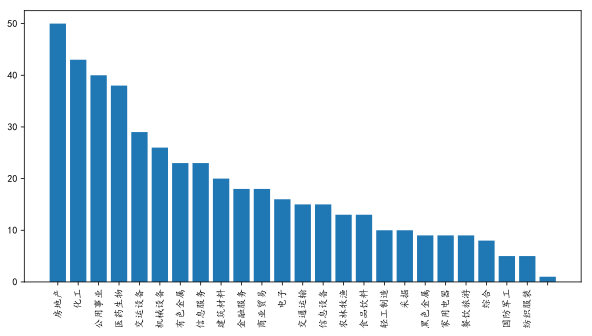

In [33]:
plt.figure(figsize=(10,5))
plt.bar(s_top.keys(),s_top.values)
plt.xticks(rotation=90)
plt.show()

# 市净率分析
## 理论上，市净率越小越好

In [58]:
df_bank = df[df['SubTrade'] == '银行']

df_bank.sort_values(by=['PB'],ascending = True)

# 市盈率增长率（PEG）
## 理论上越小越好

In [65]:
df_peg = df[df['PEG'] > 0]

df_peg[df_peg['TopTrade'] == '机械设备'].sort_values(by=['PEG'],ascending=True).head(10)

# 净资产收益率ROE÷市净率PB
## ROE应选择5%以上的为宜
## 理论上越大越好

In [74]:
df_pb = df[df['PB'] != 0]

df_pb['ROE/PB'] = df_pb['ROE'] / df_pb['PB']

df_pb[df_pb['TopTrade'] == '机械设备'].sort_values(by=['ROE/PB'],ascending=False).head(10)

In [16]:
# 根据指标获取优质股票
def getSuperiorStockByTargets(df,trade,targets,top):
    if len(targets) >= 2:
        code_list = []
        for target in targets:
            df_temp = df.copy()
            if target == 'PEG':
                df_temp = df_temp[df_temp['PEG'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'ROE/PB':
                df_temp = df_temp[df_temp['PB'] != 0]
                df_temp['ROE/PB'] = df_temp['ROE'] / df_temp['PB']
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=False).head(top)
            elif target == 'PB':
                df_temp = df_temp[df_temp['PB'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            elif target == 'PE_D':
                df_temp = df_temp[df_temp['PE_D'] > 0]
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            else:
                if trade != '':
                    df_temp = df_temp[df_temp['TopTrade'] == trade]
                df_temp = df_temp.sort_values(by=[target],ascending=True).head(top)
            
            code_list.append(list(df_temp['StockCode']))
        both = code_list[0]
        code_list.pop(0)
        while(len(code_list) > 0):
            next_list = code_list[0]
            both = [l for l in both if l in next_list]
            code_list.pop(0)
        return both
    
def getSuperiorStock(df):
    df_gpr = df.copy()
    #毛利率（高，30%~50%）
    df_gpr = df_gpr[df_gpr['GrossProfitRate'] > 30]
    
    #股本（低，小于10亿）
    df_cs = df.copy()
    df_cs = df_gpr[df_gpr['CapitalStock'] < 10]
    
    #净资产收益率（ROE）（高，大于5%）
    df_roe = df.copy()
    df_roe = df_roe[df_roe['ROE'] > 5]
    
    #小盘股
    df_sst = df.copy()
    df_sst = df_sst[df_sst['ScaleShareType'] == '小盘股']
    
    df_list = [df_gpr,df_cs,df_roe,df_sst]
    code_list = []
    for d in df_list:
        code_list.append(list(d['StockCode']))    

    both = code_list[0]
    code_list.pop(0)
    
    while(len(code_list) > 0):
        next_list = code_list[0]
        both = [l for l in both if l in next_list]
        code_list.pop(0)
    return both

In [7]:
# getSuperiorStockByTargets(df,'',['PB','PE_D'],100)

# sl = getSuperiorStock(df)

In [41]:
df_long = df[df['FinanceAnalize'].apply(lambda x:str(x).find('破净股') >= 0) & (df['PE_D'] > 0) & (df['PE_D'] < 15)]

In [42]:
df_long = df_long.sort_values(['PE_D'],ascending=True)

In [43]:
df_long.groupby(by=['TopTrade'],as_index=False).size()

TopTrade
交运设备     3
交通运输    12
公用事业     8
化工       4
医药生物     1
商业贸易     7
建筑材料     6
房地产     15
机械设备     3
纺织服装     5
综合       1
轻工制造     4
采掘      13
金融服务    19
黑色金属     4
dtype: int64

In [45]:
df_long[df_long['TopTrade'] == '金融服务']

,StockCode,StockName,PB,PE_S,PE_D,ROE,GrossProfitRate,NetAssetValuePerShare,CapitalStock,ScaleShareType,FinanceAnalize,NetProfit,NetProfitRate,TopTrade,SubTrade,PEG
368,600016,民生银行,0.66,5.58,4.443,3.77,0.00,9.75,437.82,超大盘股,"破净股,权重股,一线蓝筹,",157.92,5.69,金融服务,银行,0.980668
187,601166,兴业银行,0.83,6.27,4.832,4.41,0.00,21.97,207.74,超大盘股,"破净股,权重股,一线蓝筹,",196.58,11.35,金融服务,银行,0.552423
169,000415,渤海租赁,0.66,0.00,4.850,3.50,45.37,5.90,61.85,中盘股,"破净股,三线蓝筹,",12.68,133.79,金融服务,保险及其他,0.000000
1236,601169,北京银行,0.70,6.25,4.932,3.59,0.00,8.50,211.43,超大盘股,"破净股,权重股,一线蓝筹,",63.34,9.49,金融服务,银行,0.658588
872,601818,光大银行,0.67,5.94,5.137,13.12,0.00,5.65,524.89,超大盘股,"破净股,权重股,一线蓝筹,",97.33,7.54,金融服务,银行,0.787798
888,601288,农业银行,0.77,6.26,5.185,3.74,0.00,4.72,3499.83,超大盘股,"破净股,权重股,一线蓝筹,",612.51,4.28,金融服务,银行,1.462617
359,600000,浦发银行,0.75,6.17,5.243,3.47,0.00,15.63,293.52,超大盘股,"破净股,权重股,一线蓝筹,",164.59,15.06,金融服务,银行,0.409695
433,601009,南京银行,0.98,6.33,5.275,4.75,0.00,8.46,84.82,超大盘股,"破净股,二线蓝筹,",33.20,15.07,金融服务,银行,0.420040
538,601997,贵阳银行,0.65,5.42,5.338,4.37,0.00,13.27,32.18,中盘股,"破净股,三线蓝筹,",13.04,12.40,金融服务,银行,0.437097
537,601328,交通银行,0.69,6.21,5.428,3.25,0.00,8.87,742.63,超大盘股,"破净股,权重股,一线蓝筹,",210.71,4.88,金融服务,银行,1.272541
